<a href="https://colab.research.google.com/github/harshit4311/russell-indices-fitness-test/blob/main/russell_indices_fitness_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print('hi')

hi


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/growth_value_cumulative_returns_corrected.csv')
print(df.head())

         Date  growth_cumulative_ret  value_cumulative_ret
0  2020-01-03               0.992767              0.993286
1  2020-01-06               0.999103              0.994162
2  2020-01-07               0.997028              0.991170
3  2020-01-08               1.005271              0.993286
4  2020-01-09               1.013513              0.997665


Shapiro test p-values -> Growth: 1.1818225554974207e-15 , Value: 1.3978705166064625e-17
ADF p-values -> Growth: 0.9526074933362769 , Value: 0.7762682844068052
Correlation between Growth and Value: 0.9188574091924987


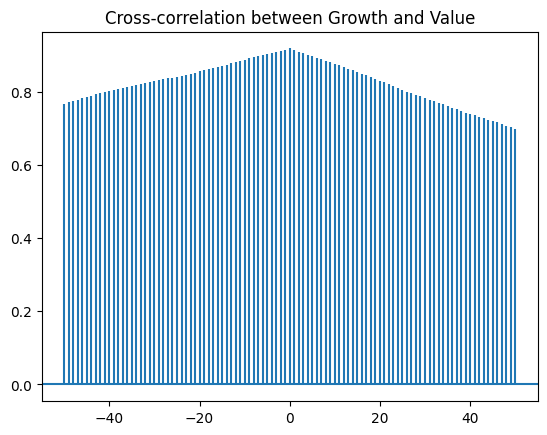

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Granger causality test completed (check p-values from results)


/tmp/ipython-input-3658884796.py:54: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma))
/tmp/ipython-input-3658884796.py:46: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = alpha*x - beta*x*y_val
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
/tmp/ipython-input-3658884796.py:46: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = alpha*x - beta*x*y_val
/tmp/ipython-input-3658884796.py:47: RuntimeWarning: overflow encountered in scalar multiply
  dydt = delta*x*y_val - gamma*y_val
/tmp/ipython-input-3658884796.py:54: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, del

LV best-fit parameters: [1.  0.1 0.1 1. ]
LV RMSE: 24.855378904042595


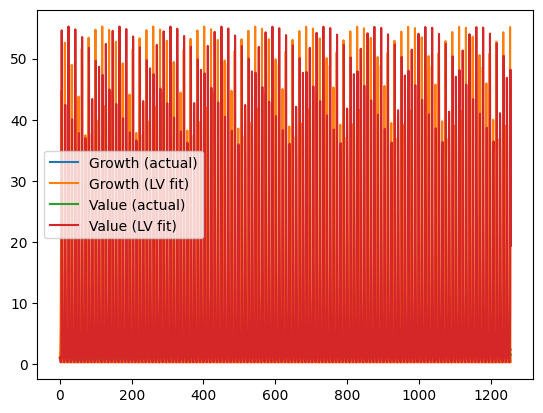

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('/content/growth_value_cumulative_returns_corrected.csv')
growth = df['growth_cumulative_ret']
value  = df['value_cumulative_ret']

# ---------- 1️⃣ Distribution Fitness ----------
# Test normality (Shapiro–Wilk test)
shapiro_growth = stats.shapiro(growth)
shapiro_value  = stats.shapiro(value)
print("Shapiro test p-values -> Growth:", shapiro_growth.pvalue, ", Value:", shapiro_value.pvalue)

# ---------- 2️⃣ Stationarity ----------
# Augmented Dickey–Fuller test
adf_growth = adfuller(growth)
adf_value  = adfuller(value)
print("ADF p-values -> Growth:", adf_growth[1], ", Value:", adf_value[1])

# ---------- 3️⃣ Cross-Correlation ----------
corr = np.corrcoef(growth, value)[0,1]
print("Correlation between Growth and Value:", corr)

# Plot cross-correlation function
plt.xcorr(growth - np.mean(growth), value - np.mean(value), maxlags=50)
plt.title("Cross-correlation between Growth and Value")
plt.show()

# ---------- 4️⃣ Granger Causality ----------
# Tests whether past values of Growth help predict Value and vice versa
granger_gv = grangercausalitytests(df[['value_cumulative_ret', 'growth_cumulative_ret']], maxlag=5, verbose=False)
granger_vg = grangercausalitytests(df[['growth_cumulative_ret', 'value_cumulative_ret']], maxlag=5, verbose=False)
print("Granger causality test completed (check p-values from results)")

# ---------- 5️⃣ Optional: Fit a simple Lotka–Volterra model ----------
from scipy.integrate import odeint

# Define LV system
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha*x - beta*x*y_val
    dydt = delta*x*y_val - gamma*y_val
    return [dxdt, dydt]

# Fit using least squares (simple version)
from scipy.optimize import curve_fit

def simulate_lv(t, alpha, beta, delta, gamma, x0, y0):
    sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma))
    return sol[:,0], sol[:,1]

# Time vector
t = np.arange(len(df))
x0, y0 = growth.iloc[0], value.iloc[0]

# Define objective function for optimization
def lv_error(params):
    alpha, beta, delta, gamma = params
    x_pred, y_pred = simulate_lv(t, alpha, beta, delta, gamma, x0, y0)
    return np.mean((growth - x_pred)**2 + (value - y_pred)**2)

from scipy.optimize import minimize
res = minimize(lv_error, x0=[1.0, 0.1, 0.1, 1.0])
print("LV best-fit parameters:", res.x)
print("LV RMSE:", np.sqrt(res.fun))

# ---------- 6️⃣ Visualize Fit ----------
x_pred, y_pred = simulate_lv(t, *res.x, x0, y0)
plt.plot(t, growth, label='Growth (actual)')
plt.plot(t, x_pred, label='Growth (LV fit)')
plt.plot(t, value, label='Value (actual)')
plt.plot(t, y_pred, label='Value (LV fit)')
plt.legend()
plt.show()


LV best-fit parameters (normalized data): [0.99999971 0.09999997 0.09999997 0.99999973]
LV RMSE (normalized data): 31.618232720119234


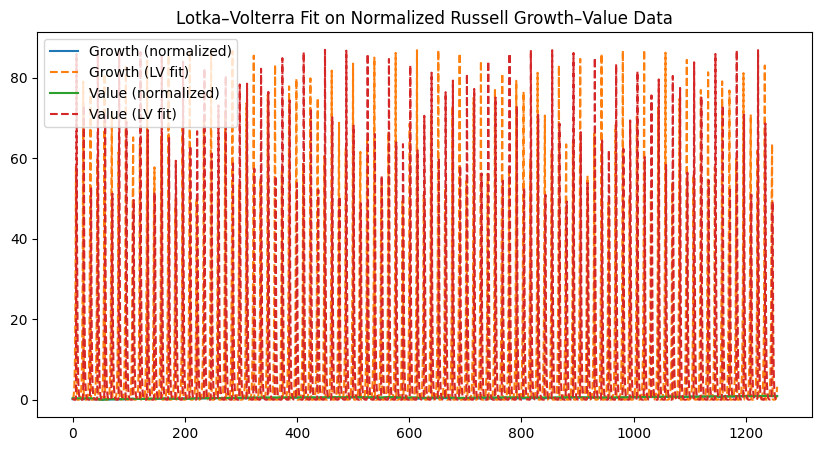

In [ ]:
from scipy.integrate import odeint
from scipy.optimize import minimize

# Normalize data to [0,1]
growth_norm = (growth - growth.min()) / (growth.max() - growth.min())
value_norm  = (value - value.min()) / (value.max() - value.min())

# Define LV system
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha*x - beta*x*y_val
    dydt = delta*x*y_val - gamma*y_val
    return [dxdt, dydt]

# Simulation function
def simulate_lv(t, alpha, beta, delta, gamma, x0, y0):
    sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), mxstep=5000)
    return sol[:,0], sol[:,1]

t = np.arange(len(df))
x0, y0 = growth_norm.iloc[0], value_norm.iloc[0]

# Objective function
def lv_error(params):
    alpha, beta, delta, gamma = params
    x_pred, y_pred = simulate_lv(t, alpha, beta, delta, gamma, x0, y0)
    if np.any(np.isnan(x_pred)) or np.any(np.isnan(y_pred)):
        return 1e6
    return np.mean((growth_norm - x_pred)**2 + (value_norm - y_pred)**2)

# Use bounds to stabilize optimization
bounds = [(0, 2), (0, 1), (0, 1), (0, 2)]
res = minimize(lv_error, x0=[1.0, 0.1, 0.1, 1.0], bounds=bounds)

print("LV best-fit parameters (normalized data):", res.x)
print("LV RMSE (normalized data):", np.sqrt(res.fun))

# Visualize
x_pred, y_pred = simulate_lv(t, *res.x, x0, y0)
plt.figure(figsize=(10,5))
plt.plot(t, growth_norm, label='Growth (normalized)')
plt.plot(t, x_pred, label='Growth (LV fit)', linestyle='--')
plt.plot(t, value_norm, label='Value (normalized)')
plt.plot(t, y_pred, label='Value (LV fit)', linestyle='--')
plt.legend()
plt.title('Lotka–Volterra Fit on Normalized Russell Growth–Value Data')
plt.show()


/tmp/ipython-input-626273658.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  dxdt = alpha*x - beta*x*y_val
/tmp/ipython-input-626273658.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  dydt = delta*x*y_val - gamma*y_val
/tmp/ipython-input-626273658.py:17: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), mxstep=5000)
/tmp/ipython-input-626273658.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = alpha*x - beta*x*y_val
/tmp/ipython-input-626273658.py:12: RuntimeWarning: overflow encountered in scalar multiply
  dydt = delta*x*y_val - gamma*y_val
/tmp/ipython-input-626273658.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  dydt = delta*x*y_val - gamma*y_val


LV best-fit parameters (DE-TRENDED): [0.00411282 0.00705142 0.00058389 0.        ]
LV RMSE (DE-TRENDED): 0.2699738366698491


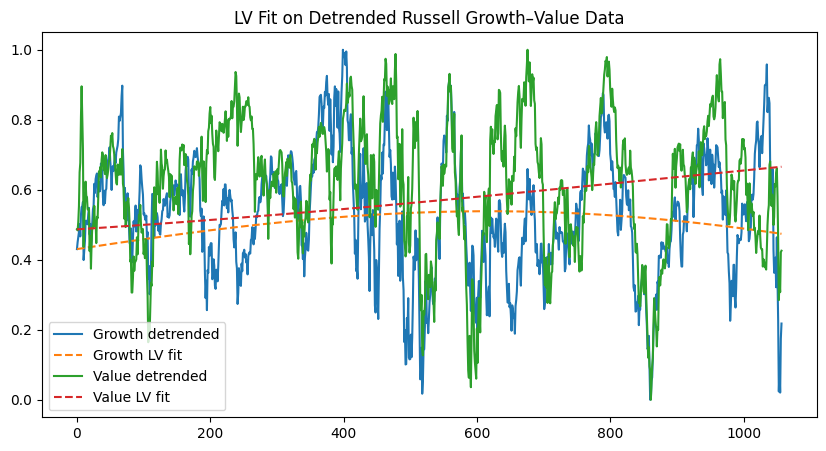

In [ ]:
# 1️⃣ Detrend (200-day rolling mean subtraction)
growth_detrended = growth - growth.rolling(200, center=True).mean()
value_detrended  = value  - value.rolling(200, center=True).mean()

# Drop NaNs from rolling window
df_det = pd.DataFrame({
    "growth_det": growth_detrended,
    "value_det": value_detrended
}).dropna()

growth_det = df_det["growth_det"]
value_det  = df_det["value_det"]

# 2️⃣ Normalize
growth_det_norm = (growth_det - growth_det.min()) / (growth_det.max() - growth_det.min())
value_det_norm  = (value_det - value_det.min()) / (value_det.max() - value_det.min())

# 3️⃣ Refit LV system
t = np.arange(len(df_det))
x0, y0 = growth_det_norm.iloc[0], value_det_norm.iloc[0]

def lv_error(params):
    alpha, beta, delta, gamma = params
    x_pred, y_pred = simulate_lv(t, alpha, beta, delta, gamma, x0, y0)
    if np.any(np.isnan(x_pred)) or np.any(np.isnan(y_pred)):
        return 1e6
    return np.mean((growth_det_norm - x_pred)**2 + (value_det_norm - y_pred)**2)

res_det = minimize(lv_error, x0=[1.0, 0.1, 0.1, 1.0], bounds=bounds)

print("LV best-fit parameters (DE-TRENDED):", res_det.x)
print("LV RMSE (DE-TRENDED):", np.sqrt(res_det.fun))

# Plot comparison
x_pred_det, y_pred_det = simulate_lv(t, *res_det.x, x0, y0)
plt.figure(figsize=(10,5))
plt.plot(t, growth_det_norm, label='Growth detrended')
plt.plot(t, x_pred_det, '--', label='Growth LV fit')
plt.plot(t, value_det_norm, label='Value detrended')
plt.plot(t, y_pred_det, '--', label='Value LV fit')
plt.legend()
plt.title('LV Fit on Detrended Russell Growth–Value Data')
plt.show()


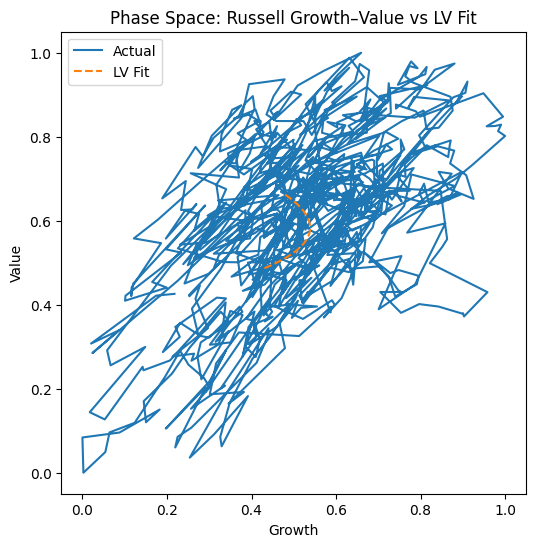

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(growth_det_norm, value_det_norm, label="Actual")
plt.plot(x_pred_det, y_pred_det, '--', label="LV Fit")
plt.xlabel("Growth")
plt.ylabel("Value")
plt.title("Phase Space: Russell Growth–Value vs LV Fit")
plt.legend()
plt.show()


## Fitness Test on an Ideal Synthetic LV Dataset

In [ ]:
ideal = pd.read_csv('/content/ideal_synthetic_LV_russell_growth_value_200.csv')
print(ideal.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/ideal_synthetic_LV_russell_growth_value_200.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Load synthetic dataset
ideal = pd.read_csv('/content/ideal_synthetic_LV_russell_growth_value_200.csv')

t = ideal['Time'].values
growth = ideal['Growth'].values
value  = ideal['Value'].values

# Normalize for numerical stability
growth_norm = (growth - growth.min()) / (growth.max() - growth.min())
value_norm  = (value - value.min()) / (value.max() - value.min())

# Define Lotka–Volterra system
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha*x - beta*x*y_val
    dydt = delta*x*y_val - gamma*y_val
    return [dxdt, dydt]

# Simulation function
def simulate_lv(t, alpha, beta, delta, gamma, x0, y0):
    sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma))
    return sol[:,0], sol[:,1]

x0, y0 = growth_norm[0], value_norm[0]

# Objective function (RMSE between true & simulated normalized series)
def lv_error(params):
    alpha, beta, delta, gamma = params
    x_pred, y_pred = simulate_lv(t, alpha, beta, delta, gamma, x0, y0)
    if np.any(np.isnan(x_pred)) or np.any(np.isnan(y_pred)):
        return 1e6
    return mean_squared_error(growth_norm, x_pred) + mean_squared_error(value_norm, y_pred)

# Fit with reasonable bounds
bounds = [(0, 3), (0, 3), (0, 3), (0, 3)]
res = minimize(lv_error, x0=[1.0, 0.5, 0.5, 1.0], bounds=bounds)

# Predictions
x_pred, y_pred = simulate_lv(t, *res.x, x0, y0)

# RMSE
rmse_growth = np.sqrt(mean_squared_error(growth_norm, x_pred))
rmse_value  = np.sqrt(mean_squared_error(value_norm, y_pred))
overall_rmse = np.sqrt((rmse_growth**2 + rmse_value**2)/2)

print(f"LV best-fit parameters: {res.x}")
print(f"RMSE (Growth): {rmse_growth:.4f}, RMSE (Value): {rmse_value:.4f}, Overall RMSE: {overall_rmse:.4f}")


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(t, growth_norm, label='Growth (true)')
plt.plot(t, x_pred, '--', label='Growth (LV fit)')
plt.plot(t, value_norm, label='Value (true)')
plt.plot(t, y_pred, '--', label='Value (LV fit)')
plt.legend()
plt.title('LV Fit on Ideal Synthetic Russell Dataset')
plt.xlabel('Time')
plt.show()

# Phase space comparison
plt.figure(figsize=(6,6))
plt.plot(growth_norm, value_norm, label='True Phase Path')
plt.plot(x_pred, y_pred, '--', label='Fitted LV Phase Path')
plt.xlabel('Growth')
plt.ylabel('Value')
plt.title('Phase Space: True vs Fitted LV')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# -------------------------
# 1. Load datasets
# -------------------------
# Real Russell data
df = pd.read_csv('/content/growth_value_cumulative_returns_corrected.csv')
growth_norm = (df['growth_cumulative_ret'] - df['growth_cumulative_ret'].min()) / (df['growth_cumulative_ret'].max() - df['growth_cumulative_ret'].min())
value_norm  = (df['value_cumulative_ret'] - df['value_cumulative_ret'].min()) / (df['value_cumulative_ret'].max() - df['value_cumulative_ret'].min())

# Detrended Russell (rolling mean)
growth_det = df['growth_cumulative_ret'] - df['growth_cumulative_ret'].rolling(200, center=True).mean()
value_det  = df['value_cumulative_ret'] - df['value_cumulative_ret'].rolling(200, center=True).mean()
df_det = pd.DataFrame({'growth': growth_det, 'value': value_det}).dropna()
growth_det_norm = (df_det['growth'] - df_det['growth'].min()) / (df_det['growth'].max() - df_det['growth'].min())
value_det_norm  = (df_det['value'] - df_det['value'].min()) / (df_det['value'].max() - df_det['value'].min())

# Ideal synthetic LV
ideal = pd.read_csv('/content/ideal_synthetic_LV_russell_growth_value_200.csv')
growth_syn_norm = (ideal['Growth'] - ideal['Growth'].min()) / (ideal['Growth'].max() - ideal['Growth'].min())
value_syn_norm  = (ideal['Value'] - ideal['Value'].min()) / (ideal['Value'].max() - ideal['Value'].min())

# -------------------------
# 2. Define LV functions
# -------------------------
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha*x - beta*x*y_val
    dydt = delta*x*y_val - gamma*y_val
    return [dxdt, dydt]

def simulate_lv(t, alpha, beta, delta, gamma, x0, y0):
    sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma))
    return sol[:,0], sol[:,1]

def fit_lv(growth_series, value_series):
    t = np.arange(len(growth_series))
    x0, y0 = growth_series[0], value_series[0]

    def lv_error(params):
        alpha, beta, delta, gamma = params
        x_pred, y_pred = simulate_lv(t, alpha, beta, delta, gamma, x0, y0)
        if np.any(np.isnan(x_pred)) or np.any(np.isnan(y_pred)):
            return 1e6
        return mean_squared_error(growth_series, x_pred) + mean_squared_error(value_series, y_pred)

    bounds = [(0, 3), (0, 3), (0, 3), (0, 3)]
    res = minimize(lv_error, x0=[1.0, 0.5, 0.5, 1.0], bounds=bounds)
    x_pred, y_pred = simulate_lv(t, *res.x, x0, y0)
    rmse_growth = np.sqrt(mean_squared_error(growth_series, x_pred))
    rmse_value  = np.sqrt(mean_squared_error(value_series, y_pred))
    overall_rmse = np.sqrt((rmse_growth**2 + rmse_value**2)/2)
    return res.x, x_pred, y_pred, rmse_growth, rmse_value, overall_rmse

# -------------------------
# 3. Fit LV to all datasets
# -------------------------
params_normal, x_fit_normal, y_fit_normal, rmse_g_n, rmse_v_n, rmse_overall_n = fit_lv(growth_norm.values, value_norm.values)
params_det, x_fit_det, y_fit_det, rmse_g_d, rmse_v_d, rmse_overall_d = fit_lv(growth_det_norm.values, value_det_norm.values)
params_syn, x_fit_syn, y_fit_syn, rmse_g_s, rmse_v_s, rmse_overall_s = fit_lv(growth_syn_norm.values, value_syn_norm.values)

# -------------------------
# 4. Visualization
# -------------------------
fig, axes = plt.subplots(2,2, figsize=(14,10))

# 4a. Time series comparison
axes[0,0].plot(growth_norm, label='Growth (normal)')
axes[0,0].plot(x_fit_normal, '--', label='Growth LV fit')
axes[0,0].plot(value_norm, label='Value (normal)')
axes[0,0].plot(y_fit_normal, '--', label='Value LV fit')
axes[0,0].set_title('Normal Dataset LV Fit')
axes[0,0].legend()

axes[0,1].plot(growth_det_norm, label='Growth (detrended)')
axes[0,1].plot(x_fit_det, '--', label='Growth LV fit')
axes[0,1].plot(value_det_norm, label='Value (detrended)')
axes[0,1].plot(y_fit_det, '--', label='Value LV fit')
axes[0,1].set_title('Detrended Dataset LV Fit')
axes[0,1].legend()

# 4b. Phase space comparison (synthetic)
axes[1,0].plot(growth_syn_norm, value_syn_norm, label='Synthetic LV')
axes[1,0].plot(x_fit_syn, y_fit_syn, '--', label='LV Fit')
axes[1,0].set_xlabel('Growth')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Phase Space: Synthetic LV')
axes[1,0].legend()

# 4c. RMSE bar plot
axes[1,1].bar(['Normal','Detrended','Synthetic'], [rmse_overall_n, rmse_overall_d, rmse_overall_s], color=['red','green','blue'])
axes[1,1].set_ylabel('Overall RMSE')
axes[1,1].set_title('LV Fit RMSE Comparison')

plt.tight_layout()
plt.show()

# -------------------------
# 5. Print RMSE Table
# -------------------------
print(f"Dataset Comparison:")
print(f"Normal: RMSE Growth={rmse_g_n:.4f}, Value={rmse_v_n:.4f}, Overall={rmse_overall_n:.4f}")
print(f"Detrended: RMSE Growth={rmse_g_d:.4f}, Value={rmse_v_d:.4f}, Overall={rmse_overall_d:.4f}")
print(f"Synthetic: RMSE Growth={rmse_g_s:.4f}, Value={rmse_v_s:.4f}, Overall={rmse_overall_s:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# -------------------------
# 1. Load datasets
# -------------------------
df = pd.read_csv('/content/growth_value_cumulative_returns_corrected.csv')
ideal = pd.read_csv('/content/ideal_synthetic_LV_russell_growth_value_200.csv')

# -------------------------
# 2. Detrend real data
# -------------------------
growth_det = df['growth_cumulative_ret'] - df['growth_cumulative_ret'].rolling(200, center=True).mean()
value_det  = df['value_cumulative_ret'] - df['value_cumulative_ret'].rolling(200, center=True).mean()
df_det = pd.DataFrame({'growth': growth_det, 'value': value_det}).dropna()

# -------------------------
# 3. Normalize all series to [0,1]
# -------------------------
def normalize(series):
    return (series - np.min(series)) / (np.max(series) - np.min(series))

growth_norm = normalize(df['growth_cumulative_ret'])
value_norm  = normalize(df['value_cumulative_ret'])

growth_det_norm = normalize(df_det['growth'])
value_det_norm  = normalize(df_det['value'])

growth_syn_norm = normalize(ideal['Growth'])
value_syn_norm  = normalize(ideal['Value'])

# -------------------------
# 4. LV functions
# -------------------------
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha*x - beta*x*y_val
    dydt = delta*x*y_val - gamma*y_val
    return [dxdt, dydt]

def simulate_lv(t, alpha, beta, delta, gamma, x0, y0):
    sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma))
    return sol[:,0], sol[:,1]

def fit_lv(growth_series, value_series):
    t = np.arange(len(growth_series))
    x0, y0 = growth_series[0], value_series[0]

    def lv_error(params):
        alpha, beta, delta, gamma = params
        x_pred, y_pred = simulate_lv(t, alpha, beta, delta, gamma, x0, y0)
        if np.any(np.isnan(x_pred)) or np.any(np.isnan(y_pred)):
            return 1e6
        return mean_squared_error(growth_series, x_pred) + mean_squared_error(value_series, y_pred)

    bounds = [(0, 3), (0, 3), (0, 3), (0, 3)]
    res = minimize(lv_error, x0=[1.0, 0.5, 0.5, 1.0], bounds=bounds)
    x_pred, y_pred = simulate_lv(t, *res.x, x0, y0)
    rmse_growth = np.sqrt(mean_squared_error(growth_series, x_pred))
    rmse_value  = np.sqrt(mean_squared_error(value_series, y_pred))
    overall_rmse = np.sqrt((rmse_growth**2 + rmse_value**2)/2)
    return res.x, x_pred, y_pred, rmse_growth, rmse_value, overall_rmse

# -------------------------
# 5. Fit LV to all datasets
# -------------------------
params_normal, x_fit_normal, y_fit_normal, rmse_g_n, rmse_v_n, rmse_overall_n = fit_lv(growth_norm.values, value_norm.values)
params_det, x_fit_det, y_fit_det, rmse_g_d, rmse_v_d, rmse_overall_d = fit_lv(growth_det_norm.values, value_det_norm.values)
params_syn, x_fit_syn, y_fit_syn, rmse_g_s, rmse_v_s, rmse_overall_s = fit_lv(growth_syn_norm.values, value_syn_norm.values)

# -------------------------
# 6. Visualization
# -------------------------
fig, axes = plt.subplots(2,2, figsize=(14,10))

# 6a. Normal dataset
axes[0,0].plot(growth_norm, label='Growth (normal)')
axes[0,0].plot(x_fit_normal, '--', label='Growth LV fit')
axes[0,0].plot(value_norm, label='Value (normal)')
axes[0,0].plot(y_fit_normal, '--', label='Value LV fit')
axes[0,0].set_title('Normal Dataset LV Fit')
axes[0,0].legend()

# 6b. Detrended dataset
axes[0,1].plot(growth_det_norm, label='Growth (detrended)')
axes[0,1].plot(x_fit_det, '--', label='Growth LV fit')
axes[0,1].plot(value_det_norm, label='Value (detrended)')
axes[0,1].plot(y_fit_det, '--', label='Value LV fit')
axes[0,1].set_title('Detrended Dataset LV Fit')
axes[0,1].legend()

# 6c. Phase space: synthetic LV
axes[1,0].plot(growth_syn_norm, value_syn_norm, label='Synthetic LV')
axes[1,0].plot(x_fit_syn, y_fit_syn, '--', label='LV Fit')
axes[1,0].set_xlabel('Growth')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Phase Space: Synthetic LV')
axes[1,0].legend()

# 6d. RMSE comparison
axes[1,1].bar(['Normal','Detrended','Synthetic'], [rmse_overall_n, rmse_overall_d, rmse_overall_s], color=['red','green','blue'])
axes[1,1].set_ylabel('Overall RMSE')
axes[1,1].set_title('LV Fit RMSE Comparison')

plt.tight_layout()
plt.show()

# -------------------------
# 7. Print RMSE Table
# -------------------------
print(f"Dataset Comparison (All normalized to [0,1]):")
print(f"Normal: RMSE Growth={rmse_g_n:.4f}, Value={rmse_v_n:.4f}, Overall={rmse_overall_n:.4f}")
print(f"Detrended: RMSE Growth={rmse_g_d:.4f}, Value={rmse_v_d:.4f}, Overall={rmse_overall_d:.4f}")
print(f"Synthetic: RMSE Growth={rmse_g_s:.4f}, Value={rmse_v_s:.4f}, Overall={rmse_overall_s:.4f}")


# --------------------------------------------------------------------------------


ADF Test for Growth (raw):
  ADF Statistic = -0.0672
  p-value       = 0.9526
  => Non-stationary

ADF Test for Value (raw):
  ADF Statistic = -0.9349
  p-value       = 0.7763
  => Non-stationary

ADF Test for Growth (detrended):
  ADF Statistic = -4.9935
  p-value       = 0.0000
  => Stationary

ADF Test for Value (detrended):
  ADF Statistic = -5.2941
  p-value       = 0.0000
  => Stationary


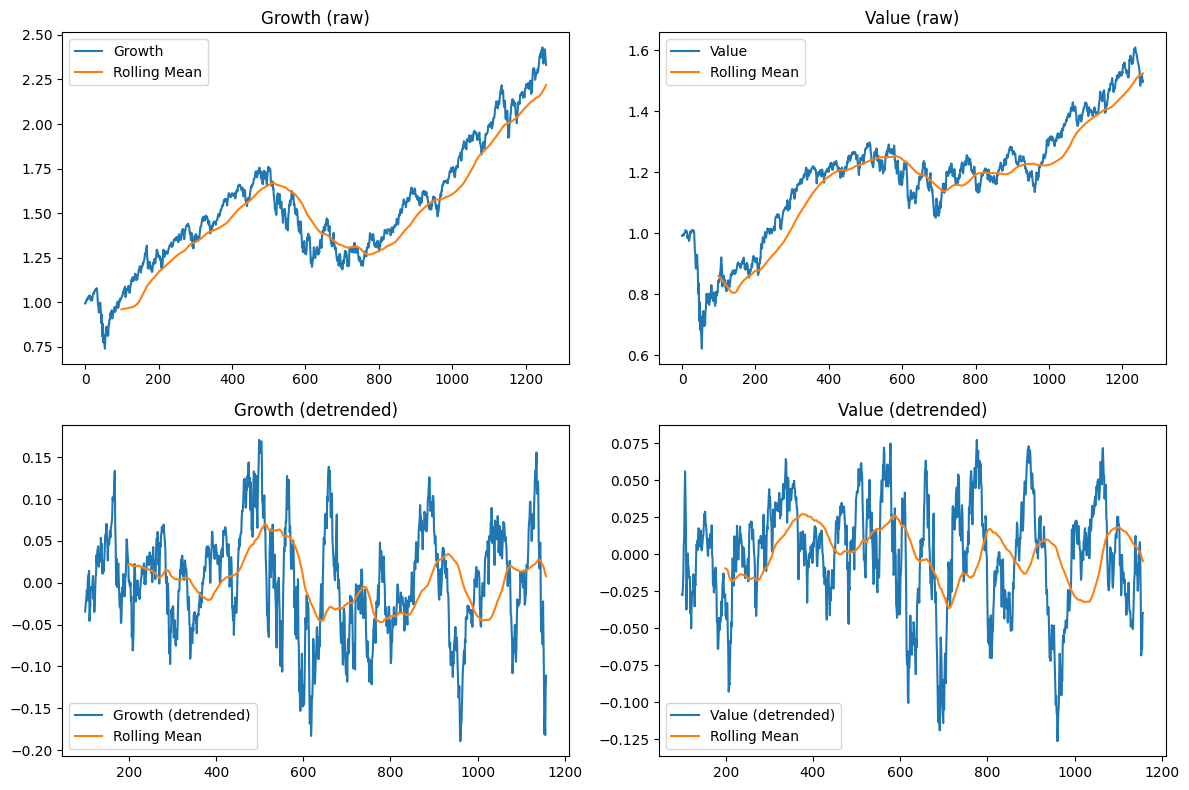


Correlation Matrix (raw):
                       growth_cumulative_ret  value_cumulative_ret
growth_cumulative_ret               1.000000              0.918857
value_cumulative_ret                0.918857              1.000000

Correlation Matrix (detrended):
         growth    value
growth  1.00000  0.52533
value   0.52533  1.00000


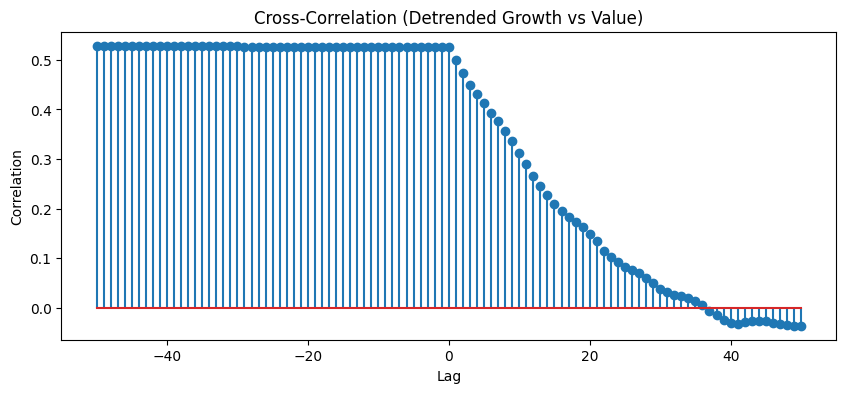

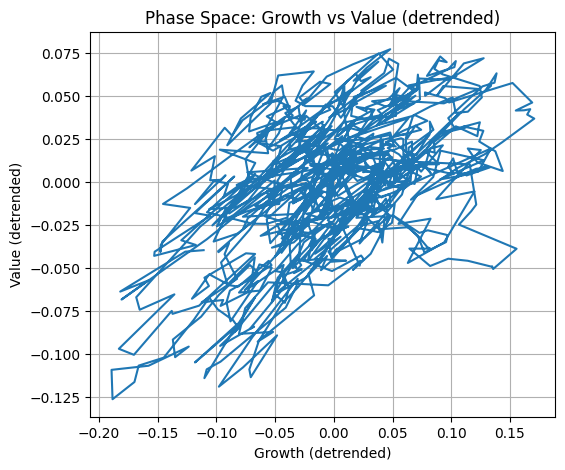

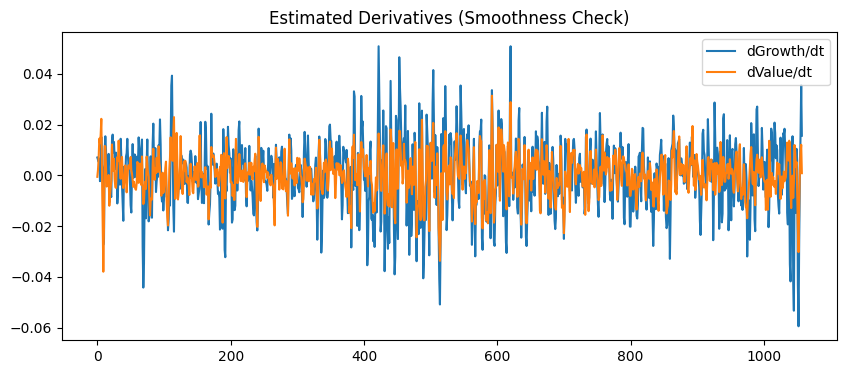

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf

# -------------------------------------------------
# 1. Load your datasets
# -------------------------------------------------
df = pd.read_csv('/content/growth_value_cumulative_returns_corrected.csv')
growth = df['growth_cumulative_ret']
value  = df['value_cumulative_ret']

# Optional: detrended versions if you already have them
growth_det = growth - growth.rolling(200, center=True).mean()
value_det  = value - value.rolling(200, center=True).mean()
df_det = pd.DataFrame({'growth': growth_det, 'value': value_det}).dropna()

# -------------------------------------------------
# 2. Stationarity (ADF test)
# -------------------------------------------------
def adf_summary(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print(f"  ADF Statistic = {result[0]:.4f}")
    print(f"  p-value       = {result[1]:.4f}")
    print("  => Stationary" if result[1] < 0.05 else "  => Non-stationary")

adf_summary(growth, "Growth (raw)")
adf_summary(value, "Value (raw)")
adf_summary(df_det['growth'], "Growth (detrended)")
adf_summary(df_det['value'], "Value (detrended)")

# -------------------------------------------------
# 3. Rolling mean and variance visualization
# -------------------------------------------------
window = 100
fig, axes = plt.subplots(2,2, figsize=(12,8))

axes[0,0].plot(growth, label='Growth')
axes[0,0].plot(growth.rolling(window).mean(), label='Rolling Mean')
axes[0,0].set_title('Growth (raw)')
axes[0,0].legend()

axes[0,1].plot(value, label='Value')
axes[0,1].plot(value.rolling(window).mean(), label='Rolling Mean')
axes[0,1].set_title('Value (raw)')
axes[0,1].legend()

axes[1,0].plot(df_det['growth'], label='Growth (detrended)')
axes[1,0].plot(df_det['growth'].rolling(window).mean(), label='Rolling Mean')
axes[1,0].set_title('Growth (detrended)')
axes[1,0].legend()

axes[1,1].plot(df_det['value'], label='Value (detrended)')
axes[1,1].plot(df_det['value'].rolling(window).mean(), label='Rolling Mean')
axes[1,1].set_title('Value (detrended)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 4. Correlation and Cross-Correlation
# -------------------------------------------------
print("\nCorrelation Matrix (raw):")
print(df[['growth_cumulative_ret','value_cumulative_ret']].corr())

print("\nCorrelation Matrix (detrended):")
print(df_det.corr())

# Cross-correlation (lag relationship)
lags = np.arange(-50, 51)
cc_vals = [np.corrcoef(df_det['growth'].shift(lag).dropna(), df_det['value'][abs(lag):])[0,1]
           for lag in lags]

plt.figure(figsize=(10,4))
# plt.stem(lags, cc_vals, use_line_collection=True)
plt.stem(lags, cc_vals)

plt.title("Cross-Correlation (Detrended Growth vs Value)")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

# -------------------------------------------------
# 5. Phase-Space Plot (Cyclic Behavior)
# -------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(df_det['growth'], df_det['value'])
plt.xlabel("Growth (detrended)")
plt.ylabel("Value (detrended)")
plt.title("Phase Space: Growth vs Value (detrended)")
plt.grid(True)
plt.show()

# -------------------------------------------------
# 6. Smoothness & Noise Check
# -------------------------------------------------
growth_deriv = np.gradient(df_det['growth'])
value_deriv  = np.gradient(df_det['value'])

plt.figure(figsize=(10,4))
plt.plot(growth_deriv, label='dGrowth/dt')
plt.plot(value_deriv, label='dValue/dt')
plt.legend()
plt.title("Estimated Derivatives (Smoothness Check)")
plt.show()


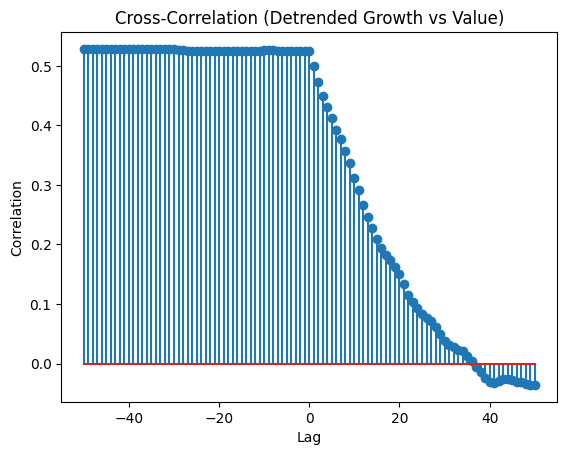

In [ ]:
plt.stem(lags, cc_vals)
plt.title("Cross-Correlation (Detrended Growth vs Value)")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()


The above plot says:
- movements in Value tend to occur slightly before corresponding movements in Growth


In predator–prey terms (Lotka–Volterra analogy):
- Value acts like the driver (predator).
- Growth behaves like the follower (prey).

Fitting LV with Growth -> Value (Growth = X, Value = Y)


/tmp/ipython-input-94158779.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = alpha * x - beta * x * y
/tmp/ipython-input-94158779.py:28: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), rtol=1e-6, atol=1e-8)
/tmp/ipython-input-94158779.py:22: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = alpha * x - beta * x * y
/tmp/ipython-input-94158779.py:23: RuntimeWarning: overflow encountered in scalar multiply
  dydt = delta * x * y - gamma * y
/tmp/ipython-input-94158779.py:28: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), rtol=1e-6, atol=1e-8)
/tmp/ipython-input-94158779.py:28: ODEintWarning: Repeated error test failures (internal error). Run with full_outp

params (alpha,beta,delta,gamma): [1.00000000e-12 1.00000000e-12 2.25709314e+00 2.15034532e+00]
RMSE growth=1.1553, value=0.9997, overall=1.0803

Fitting LV with Value -> Growth (Value = X, Growth = Y)


/tmp/ipython-input-94158779.py:28: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), rtol=1e-6, atol=1e-8)
/tmp/ipython-input-94158779.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = alpha * x - beta * x * y
/tmp/ipython-input-94158779.py:22: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = alpha * x - beta * x * y
/tmp/ipython-input-94158779.py:23: RuntimeWarning: overflow encountered in scalar multiply
  dydt = delta * x * y - gamma * y
/tmp/ipython-input-94158779.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = alpha * x - beta * x * y
/tmp/ipython-input-94158779.py:28: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), rtol=1e-6, at

params (alpha,beta,delta,gamma) for Value->Growth LV: [1.00000000e-12 1.00000000e-12 1.21043374e+00 2.54153227e+00]
RMSE value=1.2302, growth=0.9998, overall=1.1210

Best orientation: Growth -> Value
Best overall RMSE: 1.0803170359548933


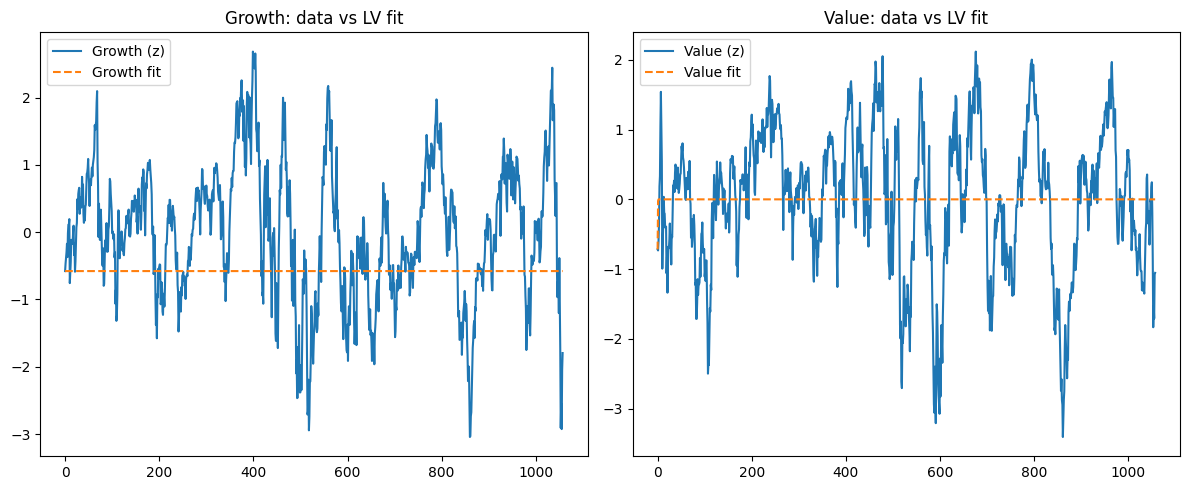

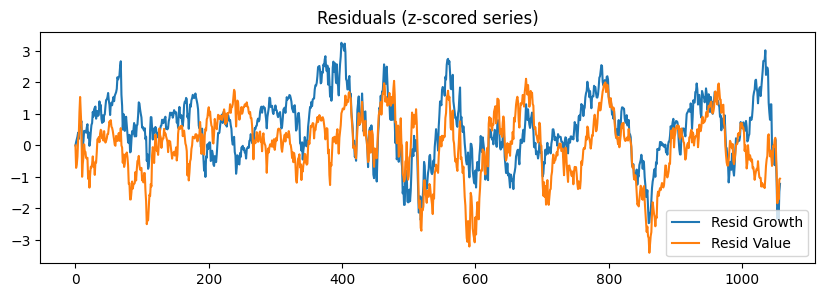

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize, differential_evolution
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- prepare series (assumes you've already created df_det with columns 'growth' and 'value') ---
g = df_det['growth'].values
v = df_det['value'].values
t = np.arange(len(g))

def zscore(s):
    s = np.asarray(s)
    return (s - np.nanmean(s)) / (np.nanstd(s) + 1e-12)

g_z = zscore(g)
v_z = zscore(v)

# --- LV system (same functional form used for both experiments) ---
def lotka_volterra(state, t, alpha, beta, delta, gamma):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

def simulate_lv(t, params, x0, y0):
    alpha, beta, delta, gamma = params
    sol = odeint(lotka_volterra, [x0, y0], t, args=(alpha, beta, delta, gamma), rtol=1e-6, atol=1e-8)
    return sol[:,0], sol[:,1]

def combined_rmse(params, t, series_x, series_y, x0=None, y0=None):
    params = np.maximum(params, 1e-12)
    if x0 is None: x0 = series_x[0]
    if y0 is None: y0 = series_y[0]
    try:
        x_pred, y_pred = simulate_lv(t, params, x0, y0)
        # Clip extreme values to prevent overflow in MSE
        x_pred = np.clip(x_pred, -1e6, 1e6)
        y_pred = np.clip(y_pred, -1e6, 1e6)
    except Exception:
        return 1e6
    if np.any(np.isnan(x_pred)) or np.any(np.isnan(y_pred)):
        return 1e6
    mse = mean_squared_error(series_x, x_pred) + mean_squared_error(series_y, y_pred)
    return np.sqrt(0.5 * mse)


# --- Fit helper: global search + local polish ---
def fit_lv_for(series_x, series_y):
    bounds = [(0, 3), (0, 3), (0, 3), (0, 3)]
    obj = lambda p: combined_rmse(p, t, series_x, series_y)
    de = differential_evolution(obj, bounds, maxiter=200, popsize=12, disp=False)
    init = de.x
    res = minimize(obj, x0=init, bounds=bounds, method='L-BFGS-B', options={'maxiter':500})
    pfit = np.maximum(res.x, 1e-12)
    x_fit, y_fit = simulate_lv(t, pfit, series_x[0], series_y[0])
    rmse_x = np.sqrt(mean_squared_error(series_x, x_fit))
    rmse_y = np.sqrt(mean_squared_error(series_y, y_fit))
    overall = np.sqrt(0.5 * (rmse_x**2 + rmse_y**2))
    return pfit, x_fit, y_fit, rmse_x, rmse_y, overall

# --- 1) Growth = X, Value = Y (default orientation) ---
print("Fitting LV with Growth -> Value (Growth = X, Value = Y)")
params_XY, xfit_XY, yfit_XY, rmse_g_XY, rmse_v_XY, overall_XY = fit_lv_for(g_z, v_z)
print("params (alpha,beta,delta,gamma):", params_XY)
print(f"RMSE growth={rmse_g_XY:.4f}, value={rmse_v_XY:.4f}, overall={overall_XY:.4f}\n")

# --- 2) Flip orientation: Value = X, Growth = Y (Value influences Growth) ---
print("Fitting LV with Value -> Growth (Value = X, Growth = Y)")
params_YX, xfit_YX, yfit_YX, rmse_v_YX, rmse_g_YX, overall_YX = fit_lv_for(v_z, g_z)
print("params (alpha,beta,delta,gamma) for Value->Growth LV:", params_YX)
print(f"RMSE value={rmse_v_YX:.4f}, growth={rmse_g_YX:.4f}, overall={overall_YX:.4f}\n")

# --- Compare and pick best orientation ---
if overall_XY < overall_YX:
    print("Best orientation: Growth -> Value")
    best_params = params_XY
    best_xfit, best_yfit = xfit_XY, yfit_XY
    best_overall = overall_XY
else:
    print("Best orientation: Value -> Growth (i.e., Value leads Growth)")
    # Note: when Value->Growth was fit, xfit_YX corresponds to Value predictions and yfit_YX to Growth predictions
    # For plotting consistency, map back to Growth, Value named variables
    best_params = params_YX
    # map predicted series back to growth/value ordering:
    best_xfit, best_yfit = yfit_YX, xfit_YX
    best_overall = overall_YX

print("Best overall RMSE:", best_overall)

# --- Plot the best fit vs data (z-scored) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(g_z, label='Growth (z)')
plt.plot(best_xfit, '--', label='Growth fit')
plt.legend()
plt.title('Growth: data vs LV fit')

plt.subplot(1,2,2)
plt.plot(v_z, label='Value (z)')
plt.plot(best_yfit, '--', label='Value fit')
plt.legend()
plt.title('Value: data vs LV fit')

plt.tight_layout()
plt.show()

# --- Residual quick-check (visual) ---
resid_g = g_z - best_xfit
resid_v = v_z - best_yfit
plt.figure(figsize=(10,3))
plt.plot(resid_g, label='Resid Growth')
plt.plot(resid_v, label='Resid Value')
plt.legend()
plt.title('Residuals (z-scored series)')
plt.show()


Residuals (Growth): mean=0.5785, std=1.0000
Residuals (Value) : mean=0.0007, std=0.9997
Residual autocorr (lag 1) Growth: 0.9512
Residual autocorr (lag 1) Value : 0.9522
Correlation Growth fit vs actual: 0.1053
Correlation Value  fit vs actual: 0.0228


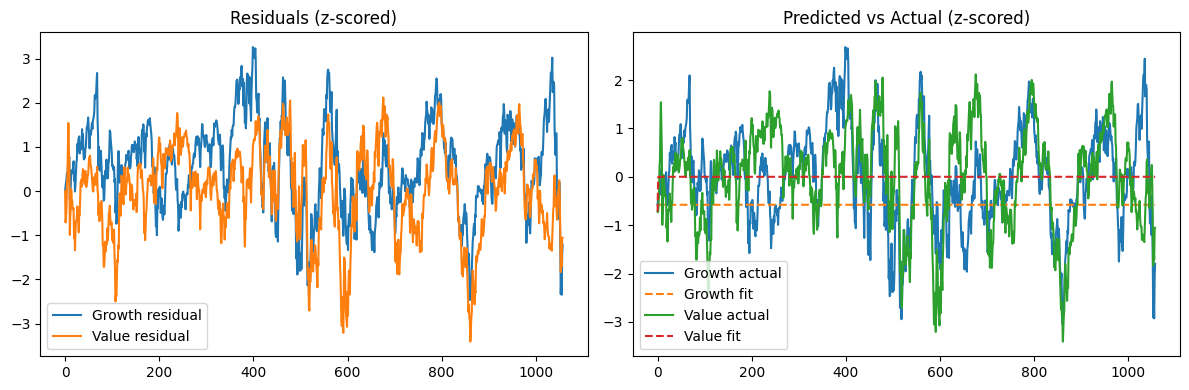

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# --- Residuals ---
resid_g = g_z - best_xfit
resid_v = v_z - best_yfit

# --- Residual stats ---
mean_resid_g = np.mean(resid_g)
std_resid_g  = np.std(resid_g)
mean_resid_v = np.mean(resid_v)
std_resid_v  = np.std(resid_v)

print(f"Residuals (Growth): mean={mean_resid_g:.4f}, std={std_resid_g:.4f}")
print(f"Residuals (Value) : mean={mean_resid_v:.4f}, std={std_resid_v:.4f}")

# --- Residual autocorrelation (lag 1 example) ---
def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0,1]

print(f"Residual autocorr (lag 1) Growth: {autocorr(resid_g):.4f}")
print(f"Residual autocorr (lag 1) Value : {autocorr(resid_v):.4f}")

# --- Correlation between predicted vs actual series ---
corr_g, _ = pearsonr(best_xfit, g_z)
corr_v, _ = pearsonr(best_yfit, v_z)

print(f"Correlation Growth fit vs actual: {corr_g:.4f}")
print(f"Correlation Value  fit vs actual: {corr_v:.4f}")

# --- Optional: Plot residuals and predicted vs actual ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(resid_g, label='Growth residual')
plt.plot(resid_v, label='Value residual')
plt.legend()
plt.title('Residuals (z-scored)')

plt.subplot(1,2,2)
plt.plot(g_z, label='Growth actual')
plt.plot(best_xfit, '--', label='Growth fit')
plt.plot(v_z, label='Value actual')
plt.plot(best_yfit, '--', label='Value fit')
plt.legend()
plt.title('Predicted vs Actual (z-scored)')

plt.tight_layout()
plt.show()


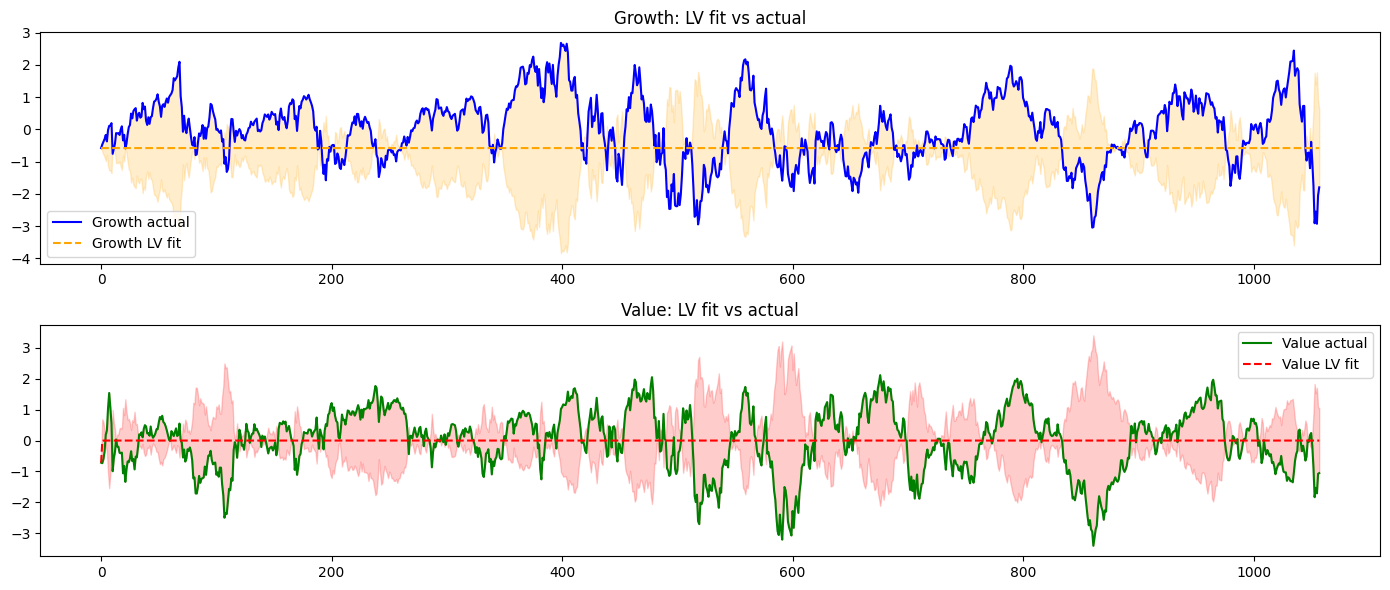

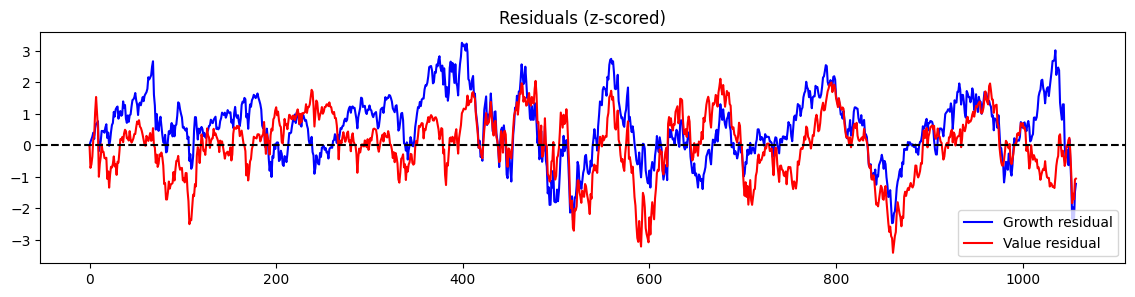

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# --- 1) Growth ---
plt.subplot(2,1,1)
plt.plot(g_z, label='Growth actual', color='blue')
plt.plot(best_xfit, '--', label='Growth LV fit', color='orange')
plt.fill_between(np.arange(len(resid_g)), best_xfit - resid_g, best_xfit + resid_g, color='orange', alpha=0.2)
plt.title('Growth: LV fit vs actual')
plt.legend()

# --- 2) Value ---
plt.subplot(2,1,2)
plt.plot(v_z, label='Value actual', color='green')
plt.plot(best_yfit, '--', label='Value LV fit', color='red')
plt.fill_between(np.arange(len(resid_v)), best_yfit - resid_v, best_yfit + resid_v, color='red', alpha=0.2)
plt.title('Value: LV fit vs actual')
plt.legend()

plt.tight_layout()
plt.show()

# --- Optional: Residuals only ---
plt.figure(figsize=(14,3))
plt.plot(resid_g, label='Growth residual', color='blue')
plt.plot(resid_v, label='Value residual', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (z-scored)')
plt.legend()
plt.show()


In [ ]:
np.corrcoef(g_z, best_xfit)[0,1], np.corrcoef(v_z, best_yfit)[0,1]


(np.float64(0.10529928257820269), np.float64(0.02275884482043119))

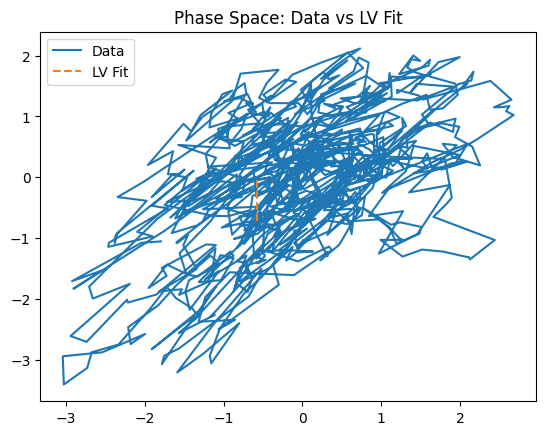

In [ ]:
plt.plot(g_z, v_z, label="Data")
plt.plot(best_xfit, best_yfit, '--', label="LV Fit")
plt.legend(); plt.title("Phase Space: Data vs LV Fit")
plt.show()


=== dx/dt regression (approx): dx/dt = c0 + c1*x + c2*(x*y) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3539
Date:                Sat, 25 Oct 2025   Prob (F-statistic):              0.702
Time:                        08:01:45   Log-Likelihood:                 936.95
No. Observations:                1038   AIC:                            -1868.
Df Residuals:                    1035   BIC:                            -1853.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

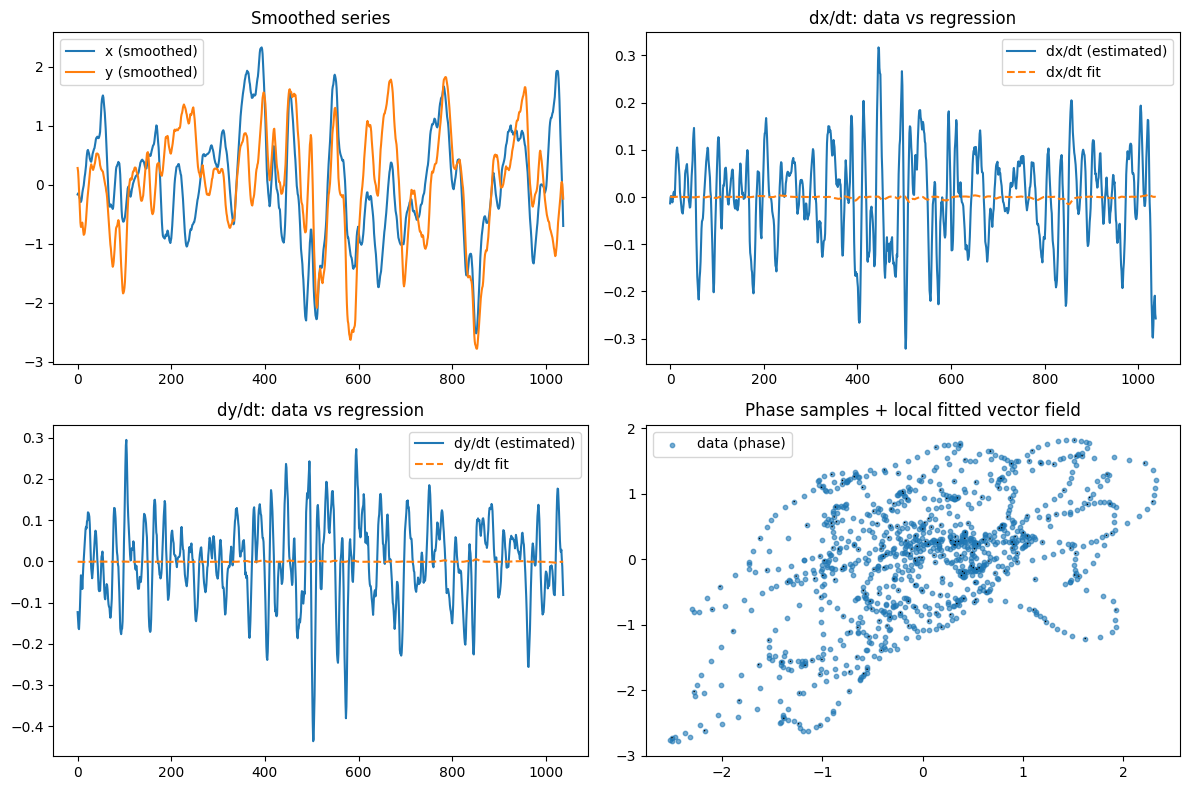


Interpretation for dx/dt ~ x + x*y:


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Differential regression (test LV via regression on derivatives)
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt

# assume g_z, v_z, t are defined (z-scored detrended series)
x = np.asarray(g_z)   # Growth (z)
y = np.asarray(v_z)   # Value  (z)
n = len(x)
dt = 1.0  # sampling interval; change if your time units differ

# --- 1) Smooth the series (Savitzky-Golay) to reduce noise before derivative ---
# window length must be odd and less than n. Choose based on data (try 11, 21, 51).
win = 21 if n >= 21 else (n // 2 * 2 + 1)  # fallback odd window
poly = 3
x_s = savgol_filter(x, win, poly, mode='interp')
y_s = savgol_filter(y, win, poly, mode='interp')

# --- 2) Estimate derivatives using SG filter (deriv=1) or finite differences ---
# Savitzky-Golay derivative:
x_dot = savgol_filter(x, win, poly, deriv=1, delta=dt, mode='interp')
y_dot = savgol_filter(y, win, poly, deriv=1, delta=dt, mode='interp')

# optional: trim edges where filter may be unstable (keep indices safe_idx)
safe = win//2
idx = np.arange(safe, n-safe)
x_s = x_s[idx]; y_s = y_s[idx]; x_dot = x_dot[idx]; y_dot = y_dot[idx]

# --- 3) Build LV-style regressors:
# LV: dx/dt = alpha*x + coeff_xy_x * (x*y)
#     dy/dt = coeff_y * y + coeff_xy_y * (x*y)
XY = x_s * y_s
# For dx/dt regression: regressors [x, x*y]
A_dx = np.column_stack([x_s, XY])
A_dx = sm.add_constant(A_dx)
model_dx = sm.OLS(x_dot, A_dx).fit()

# For dy/dt regression: regressors [y, x*y]
A_dy = np.column_stack([y_s, XY])
A_dy = sm.add_constant(A_dy)
model_dy = sm.OLS(y_dot, A_dy).fit()

# --- 4) Print results
print("=== dx/dt regression (approx): dx/dt = c0 + c1*x + c2*(x*y) ===")
print(model_dx.summary())
print("\n=== dy/dt regression (approx): dy/dt = d0 + d1*y + d2*(x*y) ===")
print(model_dy.summary())

# --- 5) Variance Inflation Factor (collinearity check) ---
def vif_df(X, names):
    X = np.asarray(X)
    vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return pd.DataFrame({'var': names, 'VIF': vifs})
print("\nVIFs for dx regressors:")
print(vif_df(A_dx[:,1:], ['x','x*y']))
print("\nVIFs for dy regressors:")
print(vif_df(A_dy[:,1:], ['y','x*y']))

# --- 6) Residual diagnostics ---
print("\nDurbin-Watson (dx residuals):", durbin_watson(model_dx.resid))
print("Durbin-Watson (dy residuals):", durbin_watson(model_dy.resid))

# --- 7) Quick plots: derivatives vs fitted ---
fig, axes = plt.subplots(2,2, figsize=(12,8))

axes[0,0].plot(x_s, label='x (smoothed)')
axes[0,0].plot(y_s, label='y (smoothed)')
axes[0,0].legend(); axes[0,0].set_title('Smoothed series')

axes[0,1].plot(x_dot, label='dx/dt (estimated)')
axes[0,1].plot(model_dx.predict(A_dx), '--', label='dx/dt fit')
axes[0,1].legend(); axes[0,1].set_title('dx/dt: data vs regression')

axes[1,0].plot(y_dot, label='dy/dt (estimated)')
axes[1,0].plot(model_dy.predict(A_dy), '--', label='dy/dt fit')
axes[1,0].legend(); axes[1,0].set_title('dy/dt: data vs regression')

# Phase-space overlay: implied vector field direction check (sample)
axes[1,1].scatter(x_s, y_s, s=10, alpha=0.6, label='data (phase)')
# compute local vector from fitted model
dx_pred = model_dx.predict(A_dx)
dy_pred = model_dy.predict(A_dy)
# sample every k points for clarity
k = max(1, len(x_s)//200)
axes[1,1].quiver(x_s[::k], y_s[::k], dx_pred[::k], dy_pred[::k], angles='xy', scale_units='xy', scale=5, width=0.003)
axes[1,1].set_title('Phase samples + local fitted vector field')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# --- 8) Interpret coefficients automatically (shortcut) ---
def interpret(model, eq):
    c = model.params
    p = model.pvalues
    print(f"\nInterpretation for {eq}:")
    print("Intercept:", c['const'], " (p=", p['const'], ")")
    # assume names: const, var1, var2
    for name, sign_exp in zip(model.params.index[1:], ['x','xy']):
        print(f"  {name}: coef={model.params[name]:.4f}, p={model.pvalues[name]:.4g}")
    print("R-squared:", model.rsquared, "Adj R2:", model.rsquared_adj)

interpret(model_dx, "dx/dt ~ x + x*y")
interpret(model_dy, "dy/dt ~ y + x*y")


Library terms: ['1' 'x' 'y' 'x^2' 'x y' 'y^2' 'x^3' 'x^2 y' 'x y^2' 'y^3']

LassoCV chosen alphas:
 alpha dx: 0.0007099067367339428  alpha dy: 0.001823116799648488

DX model (LassoCV):
       x : +1.035328e-02
       y : -8.142945e-03
     x^2 : +1.786477e-03
     x y : -1.117243e-02
   x^2 y : +4.097349e-03
   x y^2 : -9.122389e-03
Intercept: 0.00012882514747320384

DY model (LassoCV):
       x : +4.785623e-03
       y : -9.407761e-04
     x^2 : +4.904111e-03
     x^3 : +4.918140e-04
   x^2 y : +2.739909e-03
     y^3 : -1.225995e-03
Intercept: -0.0049622681727590785

DX model (STLSQ):
       x : +1.754285e-02
       y : -1.987534e-02
     x y : -1.135805e-02
   x^2 y : +1.105008e-02
   x y^2 : -2.216819e-02
     y^3 : +6.363755e-03
Intercept: 0.0

DY model (STLSQ):
       x : +2.243839e-02
       y : -1.339750e-02
     x^2 : +1.184782e-02
     x y : -1.020670e-02
     x^3 : -5.770120e-03
   x^2 y : +2.000006e-02
   x y^2 : -1.372767e-02
Intercept: 0.0

LassoDX R2 (derivative): 0.02681

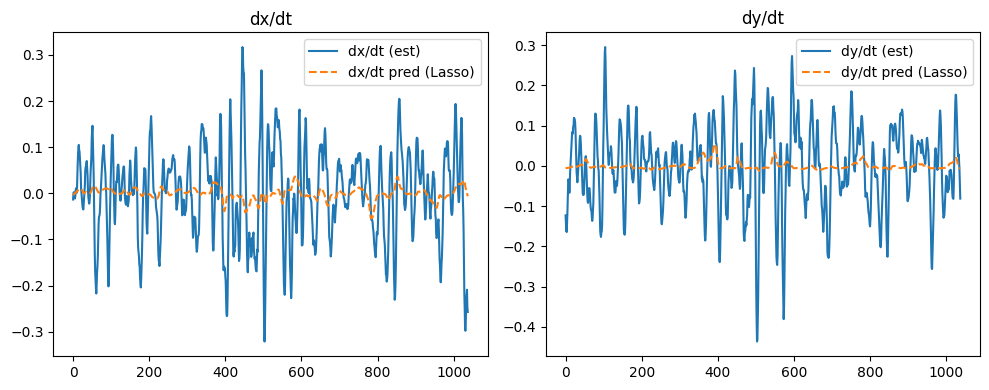

In [ ]:
# SINDy-style discovery (LassoCV and STLSQ)
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# assume x_s, y_s, x_dot, y_dot are arrays (smoothed and trimmed as before)
X = np.column_stack([x_s, y_s])
n_samples = X.shape[0]

# 1) Build polynomial library up to degree p
p = 3  # try 2 or 3
poly = PolynomialFeatures(degree=p, include_bias=True, interaction_only=False)
Theta = poly.fit_transform(X)  # shape (n_samples, n_terms)
feature_names = poly.get_feature_names_out(['x','y'])

print("Library terms:", feature_names)

# 2) Standardize Theta columns (optional but often helps)
Theta_mean = Theta.mean(axis=0)
Theta_std  = Theta.std(axis=0) + 1e-12
Theta_norm = (Theta - Theta_mean) / Theta_std

# 3) Fit LassoCV independently for dx/dt and dy/dt
cv = KFold(n_splits=5, shuffle=True, random_state=0)
lasso_dx = LassoCV(cv=cv, n_jobs=-1, random_state=0).fit(Theta_norm, x_dot)
lasso_dy = LassoCV(cv=cv, n_jobs=-1, random_state=1).fit(Theta_norm, y_dot)

coef_dx = lasso_dx.coef_ / Theta_std  # un-normalize coefficients
coef_dy = lasso_dy.coef_ / Theta_std
intercept_dx = lasso_dx.intercept_ - np.dot(Theta_mean/Theta_std, lasso_dx.coef_)
intercept_dy = lasso_dy.intercept_ - np.dot(Theta_mean/Theta_std, lasso_dy.coef_)

print("\nLassoCV chosen alphas:")
print(" alpha dx:", lasso_dx.alpha_, " alpha dy:", lasso_dy.alpha_)

# Show sparse models (list non-zero coefficients)
def show_model(coefs, intercept):
    nz = np.where(np.abs(coefs) > 1e-8)[0]
    for i in nz:
        print(f"{feature_names[i]:>8} : {coefs[i]:+.6e}")
    print("Intercept:", intercept)

print("\nDX model (LassoCV):")
show_model(coef_dx, intercept_dx)
print("\nDY model (LassoCV):")
show_model(coef_dy, intercept_dy)

# 4) Optional: STLSQ (Sequential Thresholded Least Squares)
def stlsq(Theta, target, lam=0.05, maxit=10):
    # lam = threshold; Theta not normalized here
    Xi = np.linalg.lstsq(Theta, target, rcond=None)[0]
    for _ in range(maxit):
        small = np.abs(Xi) < lam
        Xi[small] = 0
        if np.all(small):
            break
        # re-solve only for nonzero columns
        cols = ~small
        if np.sum(cols) == 0:
            break
        Xi_temp = np.zeros_like(Xi)
        Xi_temp[cols] = np.linalg.lstsq(Theta[:,cols], target, rcond=None)[0]
        if np.allclose(Xi, Xi_temp):
            Xi = Xi_temp
            break
        Xi = Xi_temp
    return Xi

lam = 0.01  # threshold, tune this
Xi_dx = stlsq(Theta_norm, x_dot, lam=lam, maxit=20) / Theta_std
Xi_dy = stlsq(Theta_norm, y_dot, lam=lam, maxit=20) / Theta_std
print("\nDX model (STLSQ):")
show_model(Xi_dx, 0.0)
print("\nDY model (STLSQ):")
show_model(Xi_dy, 0.0)

# 5) Diagnostics: explained variance and prediction plots
from sklearn.metrics import r2_score
x_dot_pred = Theta_norm.dot(lasso_dx.coef_) + lasso_dx.intercept_
y_dot_pred = Theta_norm.dot(lasso_dy.coef_) + lasso_dy.intercept_
print("\nLassoDX R2 (derivative):", r2_score(x_dot, x_dot_pred))
print("LassoDY R2 (derivative):", r2_score(y_dot, y_dot_pred))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_dot, label='dx/dt (est)')
plt.plot(x_dot_pred, '--', label='dx/dt pred (Lasso)')
plt.legend(); plt.title('dx/dt')
plt.subplot(1,2,2)
plt.plot(y_dot, label='dy/dt (est)')
plt.plot(y_dot_pred, '--', label='dy/dt pred (Lasso)')
plt.legend(); plt.title('dy/dt')
plt.tight_layout()
plt.show()
